In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import seaborn as sns
from typing import List, Optional, Dict, Tuple
from tqdm import tqdm
import numpy as np
import os
import math

# 1. Load in the data

In [2]:
# makes an object of all the prediction files
def parse_filename(filepath):
    """Extract residues and label from filename"""
    filename = os.path.basename(filepath)  # Get filename without path
    parts = filename.split('_')
    residues = parts[0]  # 'ST' or 'Y'
    label = parts[1]     # 'Phospho'
    return residues, label
    
def load_and_annotate_predictions(filepath):
    """Load a prediction file and add residues and label columns"""
    # Read the CSV
    df = pd.read_csv(filepath, sep=',')
    
    # Get residues and label from filename
    residues, label = parse_filename(filepath)
    
    # Add new columns
    df['residues'] = residues
    df['label'] = label
    
    return df

In [3]:
# Read in the prediciton files
files = [
    "/home/sander/apps/slim/ptm_predictions/ST_Phospho_Human_Peptides_1,7,30_Preds.csv",
    "/home/sander/apps/slim/ptm_predictions/Y_Phospho_Human_Peptides_1,7,30_Preds.csv"
]  
modifications = pd.concat([load_and_annotate_predictions(f) for f in files], 
                        ignore_index=True)

In [4]:
modifications.head()

,prot_id,position,pred,residues,label
0,A0A075B706,1,0.1249,ST,Phospho
1,A0A075B706,10,0.1613,ST,Phospho
2,A0A075B706,13,0.1005,ST,Phospho
3,A0A0G2JS06,40,0.0442,ST,Phospho
4,A0A0G2JS06,42,0.0299,ST,Phospho


In [220]:
# Read the different Diann results
#diann_lf = pd.read_parquet("/home/sander/apps/slim/diann_results/diann_speclib_fasta.parquet") # optional
alphadia000 = pd.read_csv("/public/compomics/sander/regular/TTOF6600_SWATH/alphadia_results/000/precursors.tsv", sep = "\t")
alphadia005 = pd.read_csv("/public/compomics/sander/regular/TTOF6600_SWATH/alphadia_results/005_C/precursors.tsv", sep = "\t")
alphadia010 = pd.read_csv("/public/compomics/sander/regular/TTOF6600_SWATH/alphadia_results/010_C/precursors.tsv", sep = "\t")
alphadia020 = pd.read_csv("/public/compomics/sander/regular/TTOF6600_SWATH/alphadia_results/020_C/precursors.tsv", sep = "\t")
alphadia040 = pd.read_csv("/public/compomics/sander/regular/TTOF6600_SWATH/alphadia_results/040_C/precursors.tsv", sep = "\t")
alphadia080 = pd.read_csv("/public/compomics/sander/regular/TTOF6600_SWATH/alphadia_results/080_C/precursors.tsv", sep = "\t")
alphadia099 = pd.read_csv("/public/compomics/sander/regular/TTOF6600_SWATH/alphadia_results/099_C/precursors.tsv", sep = "\t")

# make the diann_run_list
alphadia_runs_list = [alphadia000, alphadia005, alphadia010, alphadia020, alphadia040, alphadia080, alphadia099]

# display options: 
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

In [221]:
#alphadia000.head()

In [222]:
def create_precursor_id(row):
    """
    Creates a precursor ID from sequence, modifications, and charge information.
    Handles multiple modifications by inserting them at the correct positions.
    
    Args:
        row: DataFrame row containing sequence, mods, mod_sites, and charge
    Returns:
        String containing the formatted precursor ID
    """
    sequence = list(row['sequence'])  # Convert to list for easier modification
    
    # Handle cases with no modifications
    if pd.isna(row['mods']):
        return f"{''.join(sequence)}/{row['charge']}"
    
    # Split multiple modifications and their sites
    mods = row['mods'].split(';')
    sites = [int(site) for site in str(row['mod_sites']).split(';')]
    
    # Sort modifications by position (reversed to maintain correct positions after insertion)
    mod_pairs = sorted(zip(sites, mods), reverse=True)
    
    # Insert each modification at the correct position
    for site, mod in mod_pairs:
        mod_name = mod.split('@')[0]  # Extract modification name
        sequence.insert(site, f"[{mod_name}]")
    
    return f"{''.join(sequence)}/{row['charge']}"
    
def create_modified_peptide(row):
    """
    Creates a modified peptide string without charge information.
    Similar to precursor_id but excludes the charge state.
    """
    sequence = list(row['sequence'])
    
    if pd.isna(row['mods']):
        return ''.join(sequence)
    
    mods = row['mods'].split(';')
    sites = [int(site) for site in str(row['mod_sites']).split(';')]
    mod_pairs = sorted(zip(sites, mods), reverse=True)
    
    for site, mod in mod_pairs:
        mod_name = mod.split('@')[0]
        sequence.insert(site, f"[{mod_name}]")
    
    return ''.join(sequence)

def process_alphadia_results(alphadia_runs_list, run_ids):
    """
    Processes multiple AlphaDIA result sets and combines them into a single DataFrame.
    Now includes additional columns needed for modification mapping.
    """
    print("Starting data processing...")
    
    # Dictionary to store all unique precursor IDs and their data
    precursor_data = {}
    all_runs = set()
    
    # Dictionary to store peptide metadata
    # We'll use this to store information that's the same across all runs
    peptide_metadata = {}
    
    # Process each analysis set
    for df, run_id in tqdm(zip(alphadia_runs_list, run_ids), total=len(run_ids), desc="Processing analysis sets"):
        # Filter out decoys
        target_df = df[df['decoy'] == 0].copy()
        print(f"\nAnalysis {run_id}:")
        print(f"Total identifications: {len(df)}")
        print(f"Target identifications: {len(target_df)} ({len(target_df)/len(df)*100:.1f}%)")
        
        # Create precursor IDs and modified peptides
        target_df['precursor_id'] = target_df.apply(create_precursor_id, axis=1)
        target_df['ModifiedPeptide'] = target_df.apply(create_modified_peptide, axis=1)
        
        # Process each run's data
        for run in target_df['run'].unique():
            all_runs.add(run)
            run_data = target_df[target_df['run'] == run]
            
            # Process each precursor in this run
            for _, row in run_data.iterrows():
                precursor_id = row['precursor_id']
                
                # Store metadata for this precursor if we haven't seen it before
                if precursor_id not in peptide_metadata:
                    peptide_metadata[precursor_id] = {
                        'StrippedPeptide': row['sequence'],
                        'ModifiedPeptide': row['ModifiedPeptide'],
                        'proteins': row['proteins'],
                        'mods': row['mods'],
                        'mod_sites': row['mod_sites'],
                        'charge': row['charge']
                    }
                
                # Initialize nested dictionaries if they don't exist
                if precursor_id not in precursor_data:
                    precursor_data[precursor_id] = {}
                if run not in precursor_data[precursor_id]:
                    precursor_data[precursor_id][run] = {}
                
                # Store the data for this analysis
                precursor_data[precursor_id][run][run_id] = {
                    'found': True,
                    'qval': row['qval'],
                    'proba': row['proba']
                }
    
    print("\nCreating final DataFrame...")
    
    # Convert the nested dictionary structure to a list of rows
    rows = []
    all_runs = sorted(all_runs)
    
    # Create rows for each precursor-run combination
    for precursor_id in tqdm(precursor_data.keys(), desc="Building final matrix"):
        metadata = peptide_metadata[precursor_id]
        
        for run in all_runs:
            # Initialize row with precursor_id, run, and metadata
            row = {
                'precursor_id': precursor_id,
                'run': run,
                'StrippedPeptide': metadata['StrippedPeptide'],
                'ModifiedPeptide': metadata['ModifiedPeptide'],
                'proteins': metadata['proteins'],
                'mods': metadata['mods'],
                'mod_sites': metadata['mod_sites'],
                'charge': metadata['charge']
            }
            
            # Add data for each analysis
            for run_id in run_ids:
                analysis_data = (precursor_data.get(precursor_id, {})
                               .get(run, {})
                               .get(run_id, {'found': False, 'qval': np.nan, 'proba': np.nan}))
                
                row[f'{run_id}_found'] = analysis_data['found']
                row[f'{run_id}_qval'] = analysis_data['qval']
                row[f'{run_id}_proba'] = analysis_data['proba']
            
            rows.append(row)
    
    # Create the final DataFrame
    final_df = pd.DataFrame(rows)
    
    # Generate summary statistics
    print("\nGenerating summary statistics...")
    summary_stats = pd.DataFrame([{
        'run_id': run_id,
        'total_precursors': len(final_df[f'{run_id}_found']),
        'identified_precursors': final_df[f'{run_id}_found'].sum(),
        'mean_qval': final_df[final_df[f'{run_id}_found']][f'{run_id}_qval'].mean(),
        'median_qval': final_df[final_df[f'{run_id}_found']][f'{run_id}_qval'].median(),
        'mean_proba': final_df[final_df[f'{run_id}_found']][f'{run_id}_proba'].mean(),
        'median_proba': final_df[final_df[f'{run_id}_found']][f'{run_id}_proba'].median()
    } for run_id in run_ids])
    
    return final_df, summary_stats

In [223]:
# First, define the run IDs (even though we already have them, it's good practice to be explicit)
run_ids = ['000','005', '010', '020', '040', '080', '099']

# Run the processing function with our existing data
result_df, summary_stats = process_alphadia_results(alphadia_runs_list, run_ids)

# Sort the results just like before
result_df = result_df.sort_values(['precursor_id', 'run'])

# Let's examine what our new dataframe looks like
print("\nFirst few rows of the result dataframe:")
result_df.head()


Starting data processing...


Processing analysis sets:   0%|          | 0/7 [00:00<?, ?it/s]


Analysis 000:
Total identifications: 5666
Target identifications: 5165 (91.2%)


Processing analysis sets:  14%|█▍        | 1/7 [00:00<00:01,  4.16it/s]


Analysis 005:
Total identifications: 132492
Target identifications: 121457 (91.7%)


Processing analysis sets:  29%|██▊       | 2/7 [00:05<00:16,  3.22s/it]


Analysis 010:
Total identifications: 130069
Target identifications: 118939 (91.4%)


Processing analysis sets:  43%|████▎     | 3/7 [00:10<00:15,  3.99s/it]


Analysis 020:
Total identifications: 130422
Target identifications: 119475 (91.6%)


Processing analysis sets:  57%|█████▋    | 4/7 [00:15<00:12,  4.32s/it]


Analysis 040:
Total identifications: 129536
Target identifications: 118580 (91.5%)


Processing analysis sets:  71%|███████▏  | 5/7 [00:20<00:09,  4.54s/it]


Analysis 080:
Total identifications: 134702
Target identifications: 123526 (91.7%)


Processing analysis sets:  86%|████████▌ | 6/7 [00:25<00:04,  4.70s/it]


Analysis 099:
Total identifications: 146136
Target identifications: 133862 (91.6%)


Processing analysis sets: 100%|██████████| 7/7 [00:30<00:00,  4.37s/it]



Creating final DataFrame...


Building final matrix: 100%|██████████| 101476/101476 [00:01<00:00, 57540.75it/s]



Generating summary statistics...

First few rows of the result dataframe:


,precursor_id,run,StrippedPeptide,ModifiedPeptide,proteins,mods,mod_sites,charge,000_found,000_qval,000_proba,005_found,005_qval,005_proba,010_found,010_qval,010_proba,020_found,020_qval,020_proba,040_found,040_qval,040_proba,080_found,080_qval,080_proba,099_found,099_qval,099_proba
15441,AAAAAAALQAK/2,LFQ_TTOF6600_SWATH_Human_01,AAAAAAALQAK,AAAAAAALQAK,P36578,NaN,NaN,2,False,NaN,NaN,True,0.00000,0.000669,True,0.000562,0.003315,True,0.000587,0.002539,True,0.000000,0.000147,True,0.000358,0.000656,True,0.000000,0.000046
15442,AAAAAAALQAK/2,LFQ_TTOF6600_SWATH_Human_02,AAAAAAALQAK,AAAAAAALQAK,P36578,NaN,NaN,2,False,NaN,NaN,True,0.00000,0.000729,True,0.000204,0.003759,True,0.000000,0.000125,True,0.000113,0.001726,True,0.000268,0.002310,True,0.000000,0.000754
15443,AAAAAAALQAK/2,LFQ_TTOF6600_SWATH_Human_03,AAAAAAALQAK,AAAAAAALQAK,P36578,NaN,NaN,2,False,NaN,NaN,True,0.00000,0.000231,True,0.000827,0.007874,True,0.000000,0.000948,True,0.000000,0.001086,True,0.000259,0.003286,True,0.000000,0.000286
157284,AAAAAAGAGNR/2,LFQ_TTOF6600_SWATH_Human_01,AAAAAAGAGNR,AAAAAAGAGNR,Q9Y5R2,NaN,NaN,2,False,NaN,NaN,False,NaN,NaN,False,NaN,NaN,False,NaN,NaN,False,NaN,NaN,False,NaN,NaN,False,NaN,NaN
157285,AAAAAAGAGNR/2,LFQ_TTOF6600_SWATH_Human_02,AAAAAAGAGNR,AAAAAAGAGNR,Q9Y5R2,NaN,NaN,2,False,NaN,NaN,True,0.04668,0.124120,True,0.090069,0.177447,False,NaN,NaN,False,NaN,NaN,False,NaN,NaN,True,0.008645,0.068117


In [224]:
result_df.head()

,precursor_id,run,StrippedPeptide,ModifiedPeptide,proteins,mods,mod_sites,charge,000_found,000_qval,000_proba,005_found,005_qval,005_proba,010_found,010_qval,010_proba,020_found,020_qval,020_proba,040_found,040_qval,040_proba,080_found,080_qval,080_proba,099_found,099_qval,099_proba
15441,AAAAAAALQAK/2,LFQ_TTOF6600_SWATH_Human_01,AAAAAAALQAK,AAAAAAALQAK,P36578,NaN,NaN,2,False,NaN,NaN,True,0.00000,0.000669,True,0.000562,0.003315,True,0.000587,0.002539,True,0.000000,0.000147,True,0.000358,0.000656,True,0.000000,0.000046
15442,AAAAAAALQAK/2,LFQ_TTOF6600_SWATH_Human_02,AAAAAAALQAK,AAAAAAALQAK,P36578,NaN,NaN,2,False,NaN,NaN,True,0.00000,0.000729,True,0.000204,0.003759,True,0.000000,0.000125,True,0.000113,0.001726,True,0.000268,0.002310,True,0.000000,0.000754
15443,AAAAAAALQAK/2,LFQ_TTOF6600_SWATH_Human_03,AAAAAAALQAK,AAAAAAALQAK,P36578,NaN,NaN,2,False,NaN,NaN,True,0.00000,0.000231,True,0.000827,0.007874,True,0.000000,0.000948,True,0.000000,0.001086,True,0.000259,0.003286,True,0.000000,0.000286
157284,AAAAAAGAGNR/2,LFQ_TTOF6600_SWATH_Human_01,AAAAAAGAGNR,AAAAAAGAGNR,Q9Y5R2,NaN,NaN,2,False,NaN,NaN,False,NaN,NaN,False,NaN,NaN,False,NaN,NaN,False,NaN,NaN,False,NaN,NaN,False,NaN,NaN
157285,AAAAAAGAGNR/2,LFQ_TTOF6600_SWATH_Human_02,AAAAAAGAGNR,AAAAAAGAGNR,Q9Y5R2,NaN,NaN,2,False,NaN,NaN,True,0.04668,0.124120,True,0.090069,0.177447,False,NaN,NaN,False,NaN,NaN,False,NaN,NaN,True,0.008645,0.068117


### digest proteins the get the starting position

In [225]:
def read_proteome(canonical_proteome):
    """
    Reads the proteome sequences from the FASTA file, filters X and U aa from proteome

    Parameters:
    canonical_proteome : str
        Path to the FASTA file containing the proteome sequences

    Returns:
    dict
        A dictionary where keys are protein IDs and values are sequences
        {prot1: 'PEPTIDERRRPEPTIDE...', ...}
    """
    sequences = {}  # {prot_id: sequence}
    with open(canonical_proteome, 'r') as f:
        prot_id = None
        seq_lines = []
        for line in f:
            line = line.strip()
            if line.startswith('>'):
                if prot_id:
                    sequence = ''.join(seq_lines)
                    if 'U' not in sequence and 'X' not in sequence:
                        sequences[prot_id] = sequence
                    seq_lines = []
                prot_id = line[1:].split()[0]
            else:
                seq_lines.append(line)
        if prot_id:
            sequence = ''.join(seq_lines)
            if 'U' not in sequence and 'X' not in sequence:
                sequences[prot_id] = sequence
    return sequences

In [226]:
canonical_proteome = '/home/sander/apps/slim/general_data/UP000005640_9606_prot_id.fasta'
proteome = read_proteome(canonical_proteome)

In [227]:
# we digest the proteome just like we did when making the library: we can use peptide start position to quickly find the postions of the target modifications:
def digest_protein(sequence, missed_cleavages=0, min_length=0, max_length=None):
    """
    Performs trypsin digestion on a single protein sequence.

    Args:
        sequence (str): Protein sequence
        missed_cleavages (int): Number of allowed missed cleavages
        min_length (int): Minimum peptide length
        max_length (int): Maximum peptide length (None for no limit)

    Returns:
        list: List of tuples (peptide, start_pos) where start_pos is 0-based

    Example:
        Input: "PEPTIDERPRRPEPTIDE"
        Output: [('PEPTIDER', 0), ('PEPTIDERR', 0), ..., ('RPEPTIDE', 9)]
    """
    cleavage_sites = []
    for i in range(len(sequence) - 1):
        if sequence[i] in ('K', 'R') and sequence[i+1] != 'P':
            cleavage_sites.append(i+1)
    cleavage_sites = [0] + cleavage_sites + [len(sequence)]
    
    peptides = []
    for start_idx in range(len(cleavage_sites)-1):
        for end_idx in range(start_idx+1, min(len(cleavage_sites), start_idx+missed_cleavages+2)):
            pep_start = cleavage_sites[start_idx]
            pep_end = cleavage_sites[end_idx]
            peptide = sequence[pep_start:pep_end]
            if min_length <= len(peptide) <= (max_length if max_length else len(peptide)):
                # Validate that the peptide actually starts at pep_start
                assert sequence[pep_start:pep_start+len(peptide)] == peptide
                peptides.append((peptide, pep_start))
    return peptides

def calculate_miscleavages(peptide_seq, protein_seq, start_pos):
    """
    Calculates the number of missed cleavages in a single peptide.

    Args:
        peptide_seq (str): Peptide sequence
        protein_seq (str): Full protein sequence
        start_pos (int): Start position of peptide in protein (0-based)

    Returns:
        int: Number of missed cleavages

    Example:
        Input: ('PEPTIDERPR', 'PEPTIDERPRRPEPTIDE', 0)
        Output: 1
    """
    # Validate that the peptide actually occurs at start_pos
    assert protein_seq[start_pos:start_pos+len(peptide_seq)] == peptide_seq, \
           f"Peptide {peptide_seq} not found at position {start_pos} in protein"
    
    miscleavages = 0
    for i in range(len(peptide_seq)-1):  # Changed range to avoid going past peptide end
        abs_pos = start_pos + i  # Removed the -1 offset
        if protein_seq[abs_pos] in ('K', 'R') and protein_seq[abs_pos+1] != 'P':
            miscleavages += 1
    return miscleavages

def trypsin_digest(sequences, missed_cleavages, min_length, max_length):
    """
    Performs trypsin digestion on all protein sequences.
    
    Args:
        sequences (dict): Dictionary of protein sequences {prot_id: sequence}
        missed_cleavages (int): Number of allowed missed cleavages
        min_length (int): Minimum peptide length
        max_length (int): Maximum peptide length

    Returns:
        list: List of dictionaries containing peptide information
        
    Example:
        Input: {'prot1': 'PEPTIDERRRPEPTIDE...', ...}
        Output: [{'prot_id': 'prot1', 'sequence': 'PEPTIDERPR', 'miscleavages': 1, 
                 'peptide_length': 10, 'start_pos': 0}, ...]
    """
    digested_peptides = []
    for prot_id, seq in sequences.items():
        peptides = digest_protein(seq, missed_cleavages, min_length, max_length)
        for peptide, start_pos in peptides:
            # Validate peptide position
            assert seq[start_pos:start_pos+len(peptide)] == peptide, \
                   f"Position mismatch for peptide {peptide} in protein {prot_id}"
            
            miscleavages = calculate_miscleavages(peptide, seq, start_pos)
            digested_peptides.append({
                'prot_id': prot_id,
                'sequence': peptide,
                'miscleavages': miscleavages,
                'peptide_length': len(peptide),
                'start_pos': start_pos
            })
    return digested_peptides

In [228]:
peptides = trypsin_digest(sequences = proteome, missed_cleavages = 2, min_length = 7, max_length = 30)

In [229]:
peptides

[{'prot_id': 'A0A075B706',
  'sequence': 'TDKLIFGK',
  'miscleavages': 1,
  'peptide_length': 8,
  'start_pos': 0},
 {'prot_id': 'A0A075B706',
  'sequence': 'TDKLIFGKGTR',
  'miscleavages': 2,
  'peptide_length': 11,
  'start_pos': 0},
 {'prot_id': 'A0A075B706',
  'sequence': 'LIFGKGTR',
  'miscleavages': 1,
  'peptide_length': 8,
  'start_pos': 3},
 {'prot_id': 'A0A075B706',
  'sequence': 'LIFGKGTRVTVEP',
  'miscleavages': 2,
  'peptide_length': 13,
  'start_pos': 3},
 {'prot_id': 'A0A075B706',
  'sequence': 'GTRVTVEP',
  'miscleavages': 1,
  'peptide_length': 8,
  'start_pos': 8},
 {'prot_id': 'A0A0G2JS06',
  'sequence': 'FTCTLRSGINVGTYR',
  'miscleavages': 1,
  'peptide_length': 15,
  'start_pos': 38},
 {'prot_id': 'A0A0G2JS06',
  'sequence': 'FTCTLRSGINVGTYRIYWYQQKPGSLPR',
  'miscleavages': 2,
  'peptide_length': 28,
  'start_pos': 38},
 {'prot_id': 'A0A0G2JS06',
  'sequence': 'SGINVGTYR',
  'miscleavages': 0,
  'peptide_length': 9,
  'start_pos': 44},
 {'prot_id': 'A0A0G2JS06',
  

In [230]:
def add_modification_predictions(result_df, peptides, modifications):
    """
    Adds modification predictions to our results dataframe.
    
    Args:
        result_df (pd.DataFrame): Our processed results with ModifiedPeptide, StrippedPeptide, proteins
        peptides (list): List of peptide dictionaries with prot_id, sequence, start_pos
        modifications (pd.DataFrame): DataFrame with prot_id, position, pred for modifications
    
    Returns:
        pd.DataFrame: Original dataframe with added prediction scores
    """
    print("Adding modification predictions to results...")
    
    # Create peptides mapping dictionary for quick lookups
    peptides_dict = {}
    for p in peptides:
        key = (p['prot_id'], p['sequence'])
        if key not in peptides_dict:
            peptides_dict[key] = []
        peptides_dict[key].append(p['start_pos'])
    
    # Create modifications dictionary for quick prediction lookups
    mod_dict = modifications.set_index(['prot_id', 'position'])['pred'].to_dict()
    
    def get_prediction_for_peptide(row):
        """
        Get the highest prediction score for a peptide across all its protein positions.
        Always returns a Series with three values: prediction, best_protein, best_position
        """
        # Initialize default return values
        result = {
            'prediction': np.nan,
            'best_protein': None,
            'best_position': None
        }
        
        # Skip if no modifications or no phosphorylation
        if pd.isna(row['mods']) or 'Phospho' not in row['mods']:
            return pd.Series(result)
        
        try:
            # Find which phospho modification we're dealing with
            phospho_types = ['Phospho@S', 'Phospho@T', 'Phospho@Y']
            mod_list = row['mods'].split(';')
            phospho_mod = next((mod for mod in phospho_types if mod in mod_list), None)
            
            if not phospho_mod:
                return pd.Series(result)
            
            # Get modification position within peptide
            mod_index = mod_list.index(phospho_mod)
            mod_site = int(str(row['mod_sites']).split(';')[mod_index])
            
            # Get all protein IDs this peptide maps to
            proteins = row['proteins'].split(';')
            
            max_prediction = -1
            best_position = None
            best_protein = None
            
            # Check each protein
            for protein in proteins:
                # Get all possible start positions in this protein
                start_positions = peptides_dict.get((protein, row['StrippedPeptide']), [])
                
                # For each start position, calculate the absolute position of the modification
                for start_pos in start_positions:
                    abs_position = start_pos + mod_site
                    prediction = mod_dict.get((protein, abs_position))
                    
                    if prediction is not None and prediction > max_prediction:
                        max_prediction = prediction
                        best_position = abs_position
                        best_protein = protein
            
            # Update result if we found a prediction
            if max_prediction > -1:
                result.update({
                    'prediction': max_prediction,
                    'best_protein': best_protein,
                    'best_position': best_position
                })
                
        except Exception as e:
            print(f"Error processing row: {row}")
            print(f"Error details: {str(e)}")
            
        return pd.Series(result)
    
    # Add predictions to the dataframe
    print("Calculating predictions for each peptide...")
    new_columns = result_df.apply(get_prediction_for_peptide, axis=1)
    
    # Add the new columns to our dataframe
    for col in ['prediction', 'best_protein', 'best_position']:
        result_df[col] = new_columns[col]
    
    print("Done adding modification predictions.")
    return result_df

In [231]:
# Add predictions to our results
result_df = add_modification_predictions(result_df, peptides, modifications)

# Check the results
print("\nSample of peptides with predictions:")
result_df[result_df['prediction'].notna()].head()

Adding modification predictions to results...
Calculating predictions for each peptide...
Done adding modification predictions.

Sample of peptides with predictions:


,precursor_id,run,StrippedPeptide,ModifiedPeptide,proteins,mods,mod_sites,charge,000_found,000_qval,000_proba,005_found,005_qval,005_proba,010_found,010_qval,010_proba,020_found,020_qval,020_proba,040_found,040_qval,040_proba,080_found,080_qval,080_proba,099_found,099_qval,099_proba,prediction,best_protein,best_position
211413,AAAES[Phospho]SAIQSISHV/3,LFQ_TTOF6600_SWATH_Human_01,AAAESSAIQSISHV,AAAES[Phospho]SAIQSISHV,Q03112,Phospho@S,5,3,False,NaN,NaN,False,NaN,NaN,False,NaN,NaN,True,0.074970,0.299364,False,NaN,NaN,False,NaN,NaN,False,NaN,NaN,0.0029,Q03112,1221.0
211414,AAAES[Phospho]SAIQSISHV/3,LFQ_TTOF6600_SWATH_Human_02,AAAESSAIQSISHV,AAAES[Phospho]SAIQSISHV,Q03112,Phospho@S,5,3,False,NaN,NaN,False,NaN,NaN,False,NaN,NaN,False,NaN,NaN,False,NaN,NaN,False,NaN,NaN,False,NaN,NaN,0.0029,Q03112,1221.0
211415,AAAES[Phospho]SAIQSISHV/3,LFQ_TTOF6600_SWATH_Human_03,AAAESSAIQSISHV,AAAES[Phospho]SAIQSISHV,Q03112,Phospho@S,5,3,False,NaN,NaN,False,NaN,NaN,False,NaN,NaN,False,NaN,NaN,False,NaN,NaN,False,NaN,NaN,False,NaN,NaN,0.0029,Q03112,1221.0
213411,AAAISTS[Phospho]R/2,LFQ_TTOF6600_SWATH_Human_01,AAAISTSR,AAAISTS[Phospho]R,Q9NVU7,Phospho@S,7,2,False,NaN,NaN,False,NaN,NaN,False,NaN,NaN,True,0.085237,0.310238,False,NaN,NaN,False,NaN,NaN,False,NaN,NaN,0.2561,Q9NVU7,548.0
213412,AAAISTS[Phospho]R/2,LFQ_TTOF6600_SWATH_Human_02,AAAISTSR,AAAISTS[Phospho]R,Q9NVU7,Phospho@S,7,2,False,NaN,NaN,False,NaN,NaN,False,NaN,NaN,False,NaN,NaN,False,NaN,NaN,False,NaN,NaN,False,NaN,NaN,0.2561,Q9NVU7,548.0


In [232]:
# Create a mask for rows containing Phospho modifications
phospho_mask = result_df['mods'].str.contains('Phospho', na=False)

result_df[phospho_mask].head()

,precursor_id,run,StrippedPeptide,ModifiedPeptide,proteins,mods,mod_sites,charge,000_found,000_qval,000_proba,005_found,005_qval,005_proba,010_found,010_qval,010_proba,020_found,020_qval,020_proba,040_found,040_qval,040_proba,080_found,080_qval,080_proba,099_found,099_qval,099_proba,prediction,best_protein,best_position
211413,AAAES[Phospho]SAIQSISHV/3,LFQ_TTOF6600_SWATH_Human_01,AAAESSAIQSISHV,AAAES[Phospho]SAIQSISHV,Q03112,Phospho@S,5,3,False,NaN,NaN,False,NaN,NaN,False,NaN,NaN,True,0.074970,0.299364,False,NaN,NaN,False,NaN,NaN,False,NaN,NaN,0.0029,Q03112,1221.0
211414,AAAES[Phospho]SAIQSISHV/3,LFQ_TTOF6600_SWATH_Human_02,AAAESSAIQSISHV,AAAES[Phospho]SAIQSISHV,Q03112,Phospho@S,5,3,False,NaN,NaN,False,NaN,NaN,False,NaN,NaN,False,NaN,NaN,False,NaN,NaN,False,NaN,NaN,False,NaN,NaN,0.0029,Q03112,1221.0
211415,AAAES[Phospho]SAIQSISHV/3,LFQ_TTOF6600_SWATH_Human_03,AAAESSAIQSISHV,AAAES[Phospho]SAIQSISHV,Q03112,Phospho@S,5,3,False,NaN,NaN,False,NaN,NaN,False,NaN,NaN,False,NaN,NaN,False,NaN,NaN,False,NaN,NaN,False,NaN,NaN,0.0029,Q03112,1221.0
213411,AAAISTS[Phospho]R/2,LFQ_TTOF6600_SWATH_Human_01,AAAISTSR,AAAISTS[Phospho]R,Q9NVU7,Phospho@S,7,2,False,NaN,NaN,False,NaN,NaN,False,NaN,NaN,True,0.085237,0.310238,False,NaN,NaN,False,NaN,NaN,False,NaN,NaN,0.2561,Q9NVU7,548.0
213412,AAAISTS[Phospho]R/2,LFQ_TTOF6600_SWATH_Human_02,AAAISTSR,AAAISTS[Phospho]R,Q9NVU7,Phospho@S,7,2,False,NaN,NaN,False,NaN,NaN,False,NaN,NaN,False,NaN,NaN,False,NaN,NaN,False,NaN,NaN,False,NaN,NaN,0.2561,Q9NVU7,548.0


# Data Analysis

## waterfall plot

In [233]:
def create_waterfall_plot(result_df, thresholds=['000','005', '010', '020', '040', '080', '099'], reference_threshold='000'):
    """
    Creates a waterfall plot comparing phosphopeptide identifications across different score thresholds.
    Includes enhanced formatting and precise label positioning.
    
    Parameters:
    result_df: DataFrame containing the analysis results
    thresholds: List of threshold values to analyze
    reference_threshold: The threshold to use as baseline (default: '005')
    """
    # Filter for phosphopeptides
    phospho_mask = result_df['mods'].str.contains('Phospho', na=False)
    phospho_df = result_df[phospho_mask].copy()
    
    # Get baseline identifications using reference_threshold instead of '000'
    baseline_mask = (
        phospho_df[f'{reference_threshold}_found'] & 
        (phospho_df[f'{reference_threshold}_qval'] <= 0.01) & 
        (phospho_df[f'{reference_threshold}_proba'] <= 0.01)
    )
    baseline_ids = set(phospho_df[baseline_mask].precursor_id)
    
    # Initialize result lists
    retained = []
    lost = []
    novel = []
    
    # Process for all thresholds
    for thresh in thresholds:
        if thresh == reference_threshold:
            # For reference threshold, show all as retained
            retained.append(len(baseline_ids))
            lost.append(0)
            novel.append(0)
        else:
            thresh_mask = (
                phospho_df[f'{thresh}_found'] & 
                (phospho_df[f'{thresh}_qval'] <= 0.01) & 
                (phospho_df[f'{thresh}_proba'] <= 0.01)
            )
            thresh_ids = set(phospho_df[thresh_mask].precursor_id)
            
            retained.append(len(baseline_ids & thresh_ids))
            lost.append(-len(baseline_ids - thresh_ids))
            novel.append(len(thresh_ids - baseline_ids))
    
    # Create figure with specific size
    fig, ax = plt.subplots(figsize=(6, 6))
    
    # Plot bars
    x = np.arange(len(thresholds))
    width = 0.8
    retained_bars = ax.bar(x, retained, width, label='Retained from Baseline', color='lightblue')
    lost_bars = ax.bar(x, lost, width, label='Lost compared to Baseline', color='salmon')
    novel_bars = ax.bar(x, novel, width, bottom=retained, label='Novel compared to Baseline', color='lightgreen')
    
    # Add horizontal line at y=0
    ax.axhline(y=0, color='black', linewidth=2)
    
    # Set fixed y-axis limits and ticks
    ax.set_ylim(-30, 30)
    y_ticks = np.arange(-30, 31, 5)
    ax.set_yticks(y_ticks)
    ax.tick_params(axis='both', which='major', labelsize=18)
    
    # Customize tick labels
    ax.set_xticks(x)
    ax.set_xticklabels(thresholds, rotation=0)
    ax.set_yticklabels([str(int(abs(y))) for y in y_ticks])
    
    # Add gridlines
    ax.grid(True, axis='y', linestyle='--', alpha=1.0)
    
    # Function to add value labels with specific positioning
    def add_value_labels(values, bottom=None):
        for i, v in enumerate(values):
            if abs(v) >= 1:  # Only show labels for values >= 1
                y = bottom[i] if bottom is not None else 0
                if v > 0:
                    y = y if bottom is not None else 0
                    if bottom is not None:  # Novel values
                        if i == 0:  # Last three columns
                            ax.text(i, y + v/2, str(int(v)), ha='center', va='center',
                                  fontsize=18)
                        elif i == 1:  # Last three columns
                            ax.text(i, y + v/2, str(int(v)), ha='center', va='center',
                                  fontsize=18)
                        elif i == 2:  # Last three columns
                            ax.text(i, y + v/2, str(int(v)), ha='center', va='center',
                                  fontsize=18)
                        elif i == 3:  # Last three columns
                            ax.text(i, y + v/2, str(int(v)), ha='center', va='center',
                                  fontsize=18)
                        elif i == 4:  # Last three columns
                            ax.text(i, y + v/2, str(int(v)), ha='center', va='center',
                                  fontsize=18)
                        elif i == 5:  # Last three columns
                            ax.text(i, y + v/2+1, str(int(v)), ha='center', va='center',
                                  fontsize=18)
                        elif i == 6:  # Last three columns
                            ax.text(i, y + v/2+1, str(int(v)), ha='center', va='center',
                                  fontsize=18)

                    else:  # Retained values
                        if i == 0:  # Last three columns
                            ax.text(i, y+v/2, str(int(v)), ha='center', va='center',
                                  fontsize=18)
                        elif i == 1:  # Last three columns
                            ax.text(i, y+v/2, str(int(v)), ha='center', va='center',
                                  fontsize=18)
                        elif i == 2:  # Last three columns
                            ax.text(i, y+v/2, str(int(v)), ha='center', va='center',
                                  fontsize=18)
                        elif i == 3:  # Last three columns
                            ax.text(i, y+v/2, str(int(v)), ha='center', va='center',
                                  fontsize=18)
                        elif i == 4:  # Last three columns
                            ax.text(i, y+v/2, str(int(v)), ha='center', va='center',
                                  fontsize=18)
                        elif i == 5:  # Last three columns
                            ax.text(i, y+v/2, str(int(v)), ha='center', va='center',
                                  fontsize=18)
                        elif i == 6:  # Last three columns
                            ax.text(i, y+v/2, str(int(v)), ha='center', va='center',
                                  fontsize=18)

                else:  # Lost values
                    if i == 0:  # Last three columns
                        ax.text(i, y + v/2, str(abs(int(v))), ha='center', va='center',
                                  fontsize=18)
                    elif i == 1:  # Last three columns
                        ax.text(i, y + v/2, str(abs(int(v))), ha='center', va='center',
                                  fontsize=18)
                    elif i == 2:  # Last three columns
                        ax.text(i, y + v/2, str(abs(int(v))), ha='center', va='center',
                                  fontsize=18)
                    elif i == 3:  # Last three columns
                        ax.text(i, y + v/2, str(abs(int(v))), ha='center', va='center',
                                  fontsize=18)
                    elif i == 4:  # Last three columns
                        ax.text(i, y + v/2, str(abs(int(v))), ha='center', va='center',
                                  fontsize=18)
                    elif i == 5:  # Last three columns
                        ax.text(i, y + v/2, str(abs(int(v))), ha='center', va='center',
                                  fontsize=18)
                    elif i == 6:  # Last three columns
                        ax.text(i, y + v/2, str(abs(int(v))), ha='center', va='center',
                                  fontsize=18)
    
    # Add labels to all bar sections
    add_value_labels(retained)
    add_value_labels(lost)
    add_value_labels(novel, retained)
    
    plt.tight_layout()
    return fig

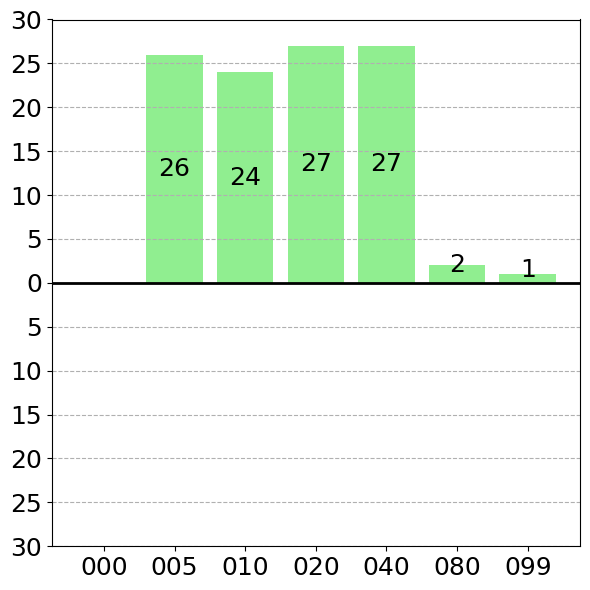

In [234]:
# Create and display the plot
fig = create_waterfall_plot(result_df)
plt.show()

prediction score distribution of 000 and qval and proba <= 0.01

In [243]:
def plot_prediction_distribution_bars(result_df, qval_threshold=0.01, proba_threshold=0.01, bin_width=0.05):
    """
    Creates an enhanced stacked bar chart showing prediction score distribution
    with vertical threshold lines and internal legend.
    """
    # Filter for phosphopeptides only
    phospho_mask = result_df['mods'].str.contains('Phospho', na=False)
    phospho_df = result_df[phospho_mask].copy()
    
    # Define thresholds and create bins
    thresholds = ['000', '005', '010', '020', '040', '080', '099']
    bins = np.arange(0, 1.1, bin_width)
    bin_centers = bins[:-1] + bin_width/2
    
    # Create figure
    fig, ax = plt.subplots(figsize=(6, 6))
    
    # Get counts for each threshold
    counts_per_threshold = []
    for threshold in thresholds:
        quality_mask = (
            (phospho_df[f'{threshold}_qval'] <= qval_threshold) & 
            (phospho_df[f'{threshold}_proba'] <= proba_threshold) &
            (phospho_df[f'{threshold}_found'])
        )
        predictions = phospho_df[quality_mask]['prediction'].dropna()
        counts, _ = np.histogram(predictions, bins=bins)
        counts_per_threshold.append(counts)
    
    # Convert to numpy array
    counts_per_threshold = np.array(counts_per_threshold)
    
    # Create stacked bar chart
    bottom = np.zeros(len(bins)-1)
    bars = []
        # Define colors for each threshold (customize as needed)
    colors = {
    '000': '#E41A1C',  
    '005': '#377EB8',  
    '010': '#4DAF4A',  
    '020': '#984EA3',  
    '040': '#FF7F00',  
    '080': '#FFFF33',  
    '099': 'Grey'  
    }

    # Update the colors list to use the dictionary values
    colors = list(colors.values())

    for i, (counts, threshold) in enumerate(zip(counts_per_threshold, thresholds)):
        bars.append(ax.bar(bin_centers, counts, bottom=bottom, width=bin_width*0.9,
                          label=f'Threshold {threshold}', color=colors[i], alpha=0.7))
        bottom += counts
    
    # Add vertical lines for thresholds
    threshold_values = [0.05, 0.10, 0.20, 0.40, 0.80, 0.99]
    line_colors = ['#000000', '#000000', '#000000', '#000000', '#000000', '#000000']
    
    for val, color in zip(threshold_values, line_colors):
        ax.axvline(x=val, color=color, linestyle='--', linewidth=1, alpha=0.7)
    
    # Add gridlines
    ax.grid(True, axis='y', linestyle='--', alpha=0.7)

    
    # Set axis limits
    ax.set_xlim(-0.05, 1.05)
    ax.set_ylim(0, 55)  # Set y-axis maximum to 35
    
    # Format axis ticks
    ax.tick_params(axis='both', which='major', labelsize=24)
    ax.set_xticks(np.arange(0, 1.1, 0.1))  # Ticks every 0.1
    # Create labels - empty string for 0.1, 0.3, 0.5, 0.7, 0.9, include 1.0
    labels = [f'{x:.1f}' if (x % 0.2 < 0.01 or x == 1.0) else '' for x in np.arange(0, 1.1, 0.1)]
    ax.set_xticklabels(labels)    
    
    plt.tight_layout()
    
    return fig

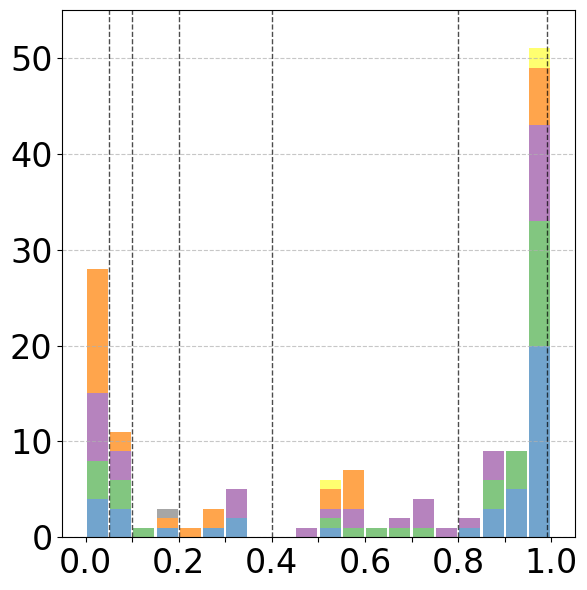

In [244]:
# Create and display the plot
fig = plot_prediction_distribution_bars(result_df)
plt.show()

# Looking at the identifications we lost

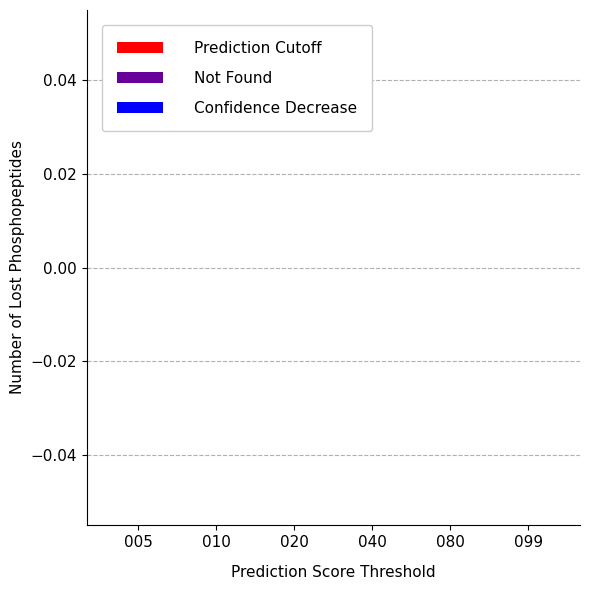

In [237]:
def analyze_identification_losses(result_df, baseline_threshold='000', confidence_threshold=0.01):
    """
    Analyzes why phosphopeptide identifications are lost as prediction score thresholds increase.
    
    The analysis categorizes losses into three main reasons:
    1. Prediction Cutoff: Lost because the prediction score was below the new threshold
    2. Not Found: The peptide wasn't identified in the run at all
    3. Confidence Decrease: The peptide was found but didn't meet quality thresholds
    
    Args:
        result_df: Our results dataframe with phosphopeptide identifications
        baseline_threshold: The reference threshold to compare against (default '000')
        confidence_threshold: Maximum q-value and probability for high-quality IDs
    """
    # Get thresholds excluding baseline
    thresholds = sorted([t for t in ['000', '005', '010', '020', '040', '080', '099'] 
                        if t != baseline_threshold])
    
    # Filter for phosphopeptides
    phospho_mask = result_df['mods'].str.contains('Phospho', na=False)
    phospho_df = result_df[phospho_mask].copy()
    
    # Get baseline high-confidence identifications
    baseline_mask = (
        (phospho_df[f'{baseline_threshold}_qval'] <= confidence_threshold) & 
        (phospho_df[f'{baseline_threshold}_proba'] <= confidence_threshold) &
        (phospho_df[f'{baseline_threshold}_found'])
    )
    baseline_ids = set(phospho_df[baseline_mask]['precursor_id'])
    
    # Initialize results dictionary
    results = {}
    
    for threshold in thresholds:
        # Get high-confidence identifications for this threshold
        threshold_mask = (
            (phospho_df[f'{threshold}_qval'] <= confidence_threshold) & 
            (phospho_df[f'{threshold}_proba'] <= confidence_threshold) &
            (phospho_df[f'{threshold}_found'])
        )
        threshold_ids = set(phospho_df[threshold_mask]['precursor_id'])
        lost_ids = baseline_ids - threshold_ids
        
        loss_reasons = {
            'Prediction Cutoff': 0,
            'Not Found': 0,
            'Confidence Decrease': 0
        }
        
        for lost_id in lost_ids:
            peptide_data = phospho_df[phospho_df['precursor_id'] == lost_id].iloc[0]
            
            # Check if peptide was found at all
            if not peptide_data[f'{threshold}_found']:
                if float(peptide_data['prediction']) < float(threshold)/100:
                    loss_reasons['Prediction Cutoff'] += 1
                else:
                    loss_reasons['Not Found'] += 1
                continue
            
            # If found but didn't pass confidence thresholds
            if (peptide_data[f'{threshold}_qval'] > confidence_threshold or 
                peptide_data[f'{threshold}_proba'] > confidence_threshold):
                loss_reasons['Confidence Decrease'] += 1
            else:
                loss_reasons['Not Found'] += 1
        
        
        results[threshold] = loss_reasons
    
    return results, thresholds

def plot_identification_losses(results, thresholds, ymax=None):
    """
    Creates a bar plot showing the distribution of reasons for lost identifications
    across different prediction score thresholds.
    """
    # Create plot
    fig, ax = plt.subplots(figsize=(6, 6))
    
    # Define colors for each category
    colors = {
        'Prediction Cutoff': '#FF0000',    # Dark red
        'Not Found': '#660099',            # Medium red
        'Confidence Decrease': '#0000FF'    # Light red
    }
    
    # Width of each bar
    bar_width = 0.25
    
    # Create positions for bars
    x = np.arange(len(thresholds))
    
    # Plot bars side by side
    reasons = list(colors.keys())
    for i, reason in enumerate(reasons):
        values = [results[threshold][reason] for threshold in thresholds]
        position = x + (i - 1) * bar_width
        bars = ax.bar(position, values, bar_width,
                     label=reason,
                     color=colors[reason])
        
        # Add value labels on bars
        for j, rect in enumerate(bars):
            height = rect.get_height()
            if height > 0:  # Only label non-zero bars
                ax.text(rect.get_x() + rect.get_width()/2., height,
                       f'{int(height)}',
                       ha='center', va='bottom',
                       fontsize=8)
    
    # Customize plot
    ax.set_xlabel('Prediction Score Threshold', fontsize=11, labelpad=11)
    ax.set_ylabel('Number of Lost Phosphopeptides', fontsize=11)
    
    # Add and customize legend
    legend = ax.legend(
        loc='upper left',
        prop={'size': 11},
        frameon=True,
        framealpha=1.0,
        markerscale=6.0,
        handlelength=3.0,
        handletextpad=2.0,
        borderpad=1.0,
        labelspacing=1.0,
        borderaxespad=1.0,
        ncol=1
    )
    
    # Set x-axis ticks
    ax.set_xticks(x)
    ax.set_xticklabels(thresholds, rotation=0, fontsize=11)
    
    # Customize y-axis
    ax.tick_params(axis='y', labelsize=11)
    ax.yaxis.grid(True, linestyle='--', alpha=1.0)
    ax.set_axisbelow(True)
    
    # Remove top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Set y-axis limits if specified
    if ymax is not None:
        ax.set_ylim(0, ymax)
        yticks = np.arange(0, ymax+1, 10)
        ax.set_yticks(yticks)
    
    plt.tight_layout()
    return fig

# Run the analysis
results, thresholds = analyze_identification_losses(result_df)

# Create the plot
fig = plot_identification_losses(results, thresholds)
plt.show()

In [245]:
def calculate_sensitivity_data(result_df, min_threshold=0.0001, max_threshold=0.05, num_points=500):
    """
    Calculate sensitivity data showing how number of phosphopeptide identifications
    varies with confidence thresholds for each analysis threshold.
    
    Args:
        result_df: DataFrame containing phosphopeptide analysis results
        min_threshold: Minimum confidence threshold to evaluate
        max_threshold: Maximum confidence threshold to evaluate
        num_points: Number of threshold points to evaluate
    """
    # Generate evenly spaced thresholds on log scale
    thresholds = np.logspace(np.log10(min_threshold), np.log10(max_threshold), num_points)
    
    # Define analysis thresholds to evaluate
    analysis_thresholds = ['000', '005', '010', '020', '040', '080']
    
    # Initialize results dictionary
    results = {thresh: [] for thresh in analysis_thresholds}
    
    # Filter for phosphopeptides
    phospho_df = result_df[result_df['mods'].str.contains('Phospho', na=False)].copy()
    
    # Calculate identifications for each threshold combination
    for confidence_threshold in thresholds:
        for analysis_threshold in analysis_thresholds:
            # Apply confidence filters for this threshold
            mask = (
                phospho_df[f'{analysis_threshold}_found'] &
                (phospho_df[f'{analysis_threshold}_qval'] <= confidence_threshold) &
                (phospho_df[f'{analysis_threshold}_proba'] <= confidence_threshold)
            )
            
            # Count unique precursors meeting criteria
            unique_precursors = phospho_df[mask]['precursor_id'].nunique()
            results[analysis_threshold].append(unique_precursors)
    
    return thresholds, results

def plot_sensitivity_data(thresholds, results):
    """
    Create sensitivity plot showing identification rates across confidence thresholds.
    Enhanced with improved visual styling and clearer data presentation.
    """
    # Define colors for different analysis thresholds with better contrast
    colors = {
    '000': '#E41A1C',  # Red
    '005': '#377EB8',  # Blue
    '010': '#4DAF4A',  # Green
    '020': '#984EA3',  # Purple
    '040': '#FF7F00',  # Orange
    '080': '#FFFF33'   # Yellow
    }
    
    # Create figure with specified dimensions
    fig, ax = plt.subplots(figsize=(6, 6))
    
    # Plot lines for each analysis threshold with enhanced styling
    for threshold in results.keys():
        ax.plot(thresholds, results[threshold], '-', 
                label=f'Threshold {threshold}',
                color=colors[threshold],
                linewidth=2)
    
    # Add reference line at standard threshold (0.01)
    ax.axvline(x=0.01, color='black', linestyle='--', linewidth=1, alpha=0.7,
               label='Confidence Threshold (0.01)')
    
    # Customize axes with clear labeling
    ax.set_xscale('log')
    ax.tick_params(axis='x', labelsize=24)
    
    # Set tick positions and labels for clear reading
    ax.xaxis.set_minor_locator(plt.NullLocator())
    
    # Set y-axis limits and ticks for optimal data display
    ax.set_ylim(0, 350)
    ax.set_yticks(np.arange(0, 351, 50))
    ax.set_yticklabels([str(int(y)) for y in np.arange(0, 351, 50)], 
                       fontsize=24)
    
    # Add grid for better readability
    ax.grid(True, which='major', linestyle='--', alpha=0.7)
    # Add legend with larger font
    
    plt.tight_layout()
    return fig

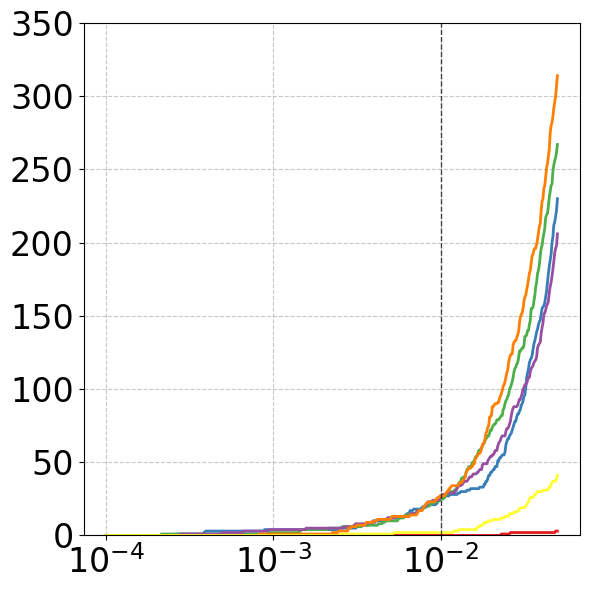

In [246]:
# Calculate sensitivity data
thresholds, results = calculate_sensitivity_data(result_df)

# Create and display the plot
fig = plot_sensitivity_data(thresholds, results)
plt.show()

## Gained identifications

/tmp/ipykernel_234560/944821225.py:140: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


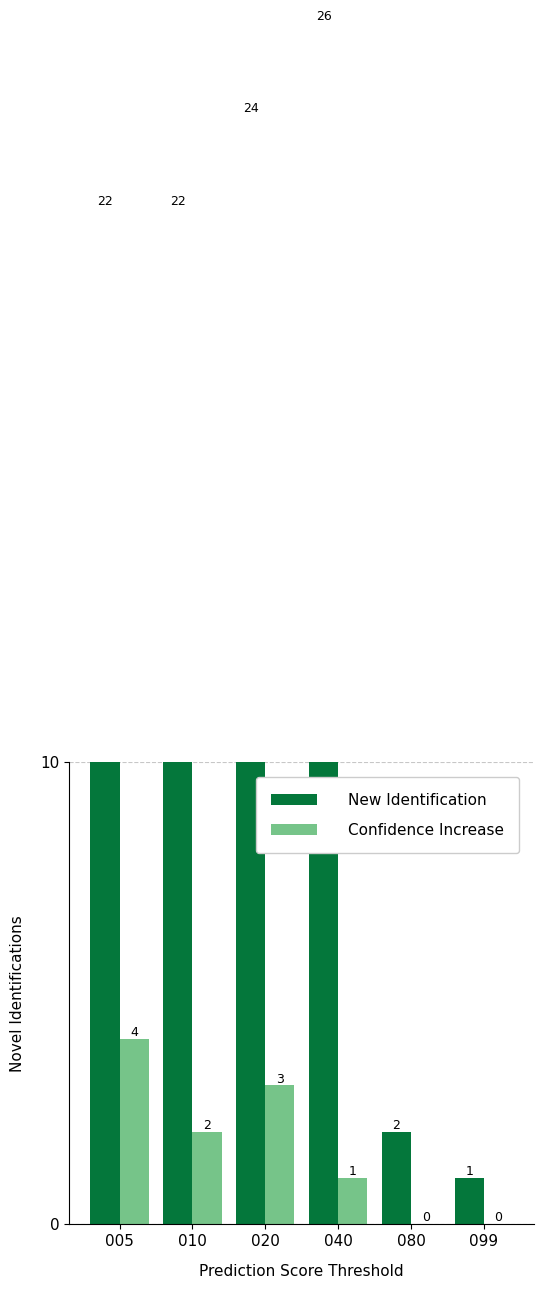

In [247]:
def analyze_novel_identifications(result_df, baseline_threshold='000', confidence_threshold=0.01):
    """
    Analyzes reasons for novel phosphopeptide identifications compared to baseline threshold.
    This function aggregates data across all runs to give an overall picture of gains.
    
    Args:
        result_df: DataFrame containing phosphopeptide identifications and their metrics
        baseline_threshold: Reference threshold to compare against (default '000')
        confidence_threshold: Maximum q-value and probability for high-quality IDs
        
    Returns:
        tuple: (results dictionary containing gain reasons, list of analyzed thresholds)
    """
    # Get thresholds excluding baseline
    thresholds = sorted([t for t in ['000', '005', '010', '020', '040', '080', '099'] 
                        if t != baseline_threshold])
    
    # Filter for phosphopeptides
    phospho_mask = result_df['mods'].str.contains('Phospho', na=False)
    phospho_df = result_df[phospho_mask].copy()
    
    # Get baseline identifications (both all and confident)
    baseline_mask = phospho_df[f'{baseline_threshold}_found']
    baseline_ids = set(phospho_df[baseline_mask]['precursor_id'])
    
    baseline_confident_mask = (
        baseline_mask & 
        (phospho_df[f'{baseline_threshold}_qval'] <= confidence_threshold) &
        (phospho_df[f'{baseline_threshold}_proba'] <= confidence_threshold)
    )
    baseline_confident_ids = set(phospho_df[baseline_confident_mask]['precursor_id'])
    
    # Initialize results dictionary to store gains for each threshold
    results = {}
    
    # Analyze each threshold
    for threshold in thresholds:
        # Identify confident peptides at this threshold
        threshold_mask = (
            phospho_df[f'{threshold}_found'] &
            (phospho_df[f'{threshold}_qval'] <= confidence_threshold) &
            (phospho_df[f'{threshold}_proba'] <= confidence_threshold)
        )
        threshold_ids = set(phospho_df[threshold_mask]['precursor_id'])
        
        # Find and categorize novel identifications
        novel_ids = threshold_ids - baseline_confident_ids
        gain_reasons = {
            'Confidence Increase': 0,
            'New Identification': 0
        }
        
        # Categorize each novel identification
        for novel_id in novel_ids:
            if novel_id in baseline_ids:
                gain_reasons['Confidence Increase'] += 1
            else:
                gain_reasons['New Identification'] += 1
        
        results[threshold] = gain_reasons
    
    return results, thresholds

def plot_novel_identifications(results, thresholds, ymax=10):
    """
    Creates a bar plot showing the distribution of reasons for novel identifications
    at different prediction score thresholds.
    
    Args:
        results: Dictionary containing gain reasons for each threshold
        thresholds: List of analyzed thresholds
        ymax: Maximum y-axis value for the plot
        
    Returns:
        matplotlib figure object
    """
    # Create plot with specified size
    fig, ax = plt.subplots(figsize=(6, 6))
    
    # Define colors for clear visual distinction between gain types
    colors = {
        'New Identification': '#04773B',    # Dark green
        'Confidence Increase': '#76C489'    # Light green
    }
    
    # Set up bars
    bar_width = 0.40
    x = np.arange(len(thresholds))
    
    # Plot bars for each type of gain
    reasons = list(colors.keys())
    for i, reason in enumerate(reasons):
        values = [results[threshold][reason] for threshold in thresholds]
        position = x + (i - 0.5) * bar_width
        bars = ax.bar(position, values, bar_width,
                     label=reason,
                     color=colors[reason])
        
        # Add value labels on bars
        for j, rect in enumerate(bars):
            height = rect.get_height()
            ax.text(rect.get_x() + rect.get_width()/2., height,
                   f'{int(height)}',
                   ha='center', va='bottom',
                   fontsize=9)
    
    # Customize plot appearance
    ax.set_xlabel('Prediction Score Threshold', fontsize=11, labelpad=11)
    ax.set_ylabel('Novel Identifications', fontsize=11, labelpad=11)
    
    # Create and customize legend
    legend = ax.legend(
        loc='upper right',
        prop={'size': 11},
        frameon=True,
        framealpha=1.0,
        markerscale=6.0,
        handlelength=3.0,
        handletextpad=2.0,
        borderpad=1.0,
        labelspacing=1.0,
        borderaxespad=1.0,
        ncol=1,
        columnspacing=1.0
    )
    
    # Set up axes and grid
    ax.set_xticks(x)
    ax.set_xticklabels(thresholds, rotation=0, fontsize=11)
    ax.tick_params(axis='y', labelsize=11)
    ax.yaxis.grid(True, linestyle='--', alpha=0.7)
    ax.set_axisbelow(True)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Set y-axis limits and ticks
    ax.set_ylim(0, ymax)
    ax.set_yticks(np.arange(0, ymax + 1, 10))
    
    plt.tight_layout()
    return fig

# Run the analysis and create the visualization
results, thresholds = analyze_novel_identifications(result_df)
fig = plot_novel_identifications(results, thresholds)
plt.show()